# Train Trip Duration Model

## 1. Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [32]:
# Use mlflow
import mlflow

# Run mlflow in sqlite
mlflow.set_tracking_uri('sqlite:///mlflow.db')

# Create experiment if not exist, set experiment if already exist
mlflow.set_experiment('nyc-taxi-experiment-23')

2025/02/17 21:11:28 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment-23' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/arief/Desktop/projects/mlops_zoomcamp/module_2/mlruns/2', creation_time=1739801488499, experiment_id='2', last_update_time=1739801488499, lifecycle_stage='active', name='nyc-taxi-experiment-23', tags={}>

## 2. Load Data

In [3]:
df = pd.read_parquet('green_tripdata_2021-01.parquet')
print(len(df))
df.head()

76518


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [4]:
## Filter trip type
# df = df[df['trip_type'] == 2]

# Change column type
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])

df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [5]:
# Get trip duration
df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']

# Change duration to minutes
df['duration'] = df['duration'].apply(lambda d: d.total_seconds()/60)

df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,...,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00,0.066667


/tmp/ipykernel_8973/2904061269.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.duration)


<Axes: xlabel='duration', ylabel='Density'>

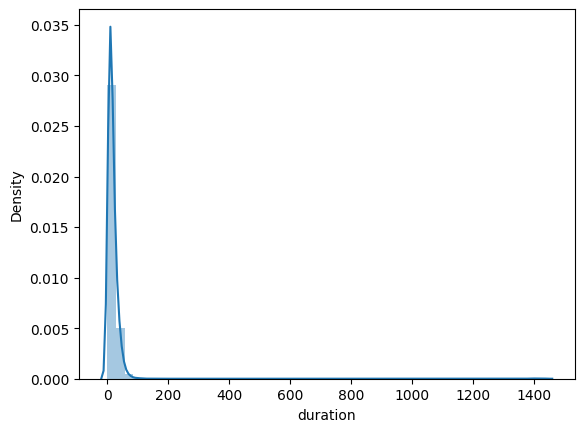

In [6]:
# Look at the distribution of duration
sns.distplot(df.duration)

In [7]:
df.duration.describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

In [8]:
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [9]:
df = df.query('1 <= duration <=60')
print(len(df))
df.head()

73908


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.5,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667


## 3. Feature Selection

In [10]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [11]:
# Change datatype to str so we can perform one hot encoding on it
df[categorical] = df[categorical].astype(str)

In [12]:
train_dicts = df[categorical + numerical].to_dict(orient='records')
# train_dicts

In [13]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [14]:
# Label/target
target = 'duration'
y_train = df[target].values

## 4. Train Model

In [15]:
def read_dataframe(filename):
    
    df = pd.read_parquet(filename)    
    # Change column type
    df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
    df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])

    # Get trip duration
    df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
    # Change duration to minutes
    df['duration'] = df['duration'].apply(lambda d: d.total_seconds()/60)
    df = df.query('1 <= duration <=60')

    categorical = ['PULocationID', 'DOLocationID']
    # Change datatype to str so we can perform one hot encoding on it
    df[categorical] = df[categorical].astype(str)
    
    return df

In [16]:
df_train = read_dataframe('green_tripdata_2021-01.parquet')
df_val = read_dataframe('green_tripdata_2021-02.parquet')

/tmp/ipykernel_8973/76047919.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)
/tmp/ipykernel_8973/76047919.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


In [17]:
print(len(df_train))
print(len(df_val))

73908
61921


In [18]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [19]:
# Label/target
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [20]:
# Train a linear regression model
linear_regression = LinearRegression()

linear_regression.fit(X_train, y_train)
y_pred = linear_regression.predict(X_val)

print(mean_squared_error(y_val, y_pred, squared=False))
print(mean_absolute_error(y_val, y_pred))

10.496651120495255
7.6040517359442


In [21]:
# Train a lasso regression model
lasso_regression = Lasso(alpha=0.001)

lasso_regression.fit(X_train, y_train)
y_pred = lasso_regression.predict(X_val)

print(mean_squared_error(y_val, y_pred, squared=False))
print(mean_absolute_error(y_val, y_pred))

10.481255832596219
7.601812923657592


In [22]:
# Train a lasso regression model
ridge_regression = Ridge()

ridge_regression.fit(X_train, y_train)
y_pred = ridge_regression.predict(X_val)

print(mean_squared_error(y_val, y_pred, squared=False))
print(mean_absolute_error(y_val, y_pred))

10.478171095846404
7.583645902844641


## 5. Modify Features

In [23]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [24]:
categorical = ['PU_DO']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [25]:
# Train a linear regression model
linear_regression = LinearRegression()

linear_regression.fit(X_train, y_train)
y_pred = linear_regression.predict(X_val)

print(mean_squared_error(y_val, y_pred, squared=False))
print(mean_absolute_error(y_val, y_pred))

7.758715208537182
5.339713111662927


In [26]:
with mlflow.start_run():

    mlflow.set_tag("developer", "arief")

    # Track data and hyperparameters with log_param
    mlflow.log_param("train-data-path", "green_tripdata_2021-01.parquet")
    mlflow.log_param("val-data-path", "green_tripdata_2021-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    # Train a lasso regression model
    lasso_regression = Lasso(alpha)

    lasso_regression.fit(X_train, y_train)
    y_pred = lasso_regression.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)

    # Track metric with log_metric
    mlflow.log_metric("rmse", rmse)

In [27]:
# Save linear regression model
import pickle

with open('lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, linear_regression), f_out)

## 6. Hyperparameter Tuning

In [30]:
# Hyperparameter tuning with hyperopt
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [34]:
# Prepare data for xgboost
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [35]:
def objective(params):

    with mlflow.start_run():

        mlflow.set_tag("model", "xgboost")

        # Use log_params instead of log_param to log multiple
        # parameters simultaneously
        mlflow.log_params(params)

        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )

        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
    
        # Track metric with log_metric
        mlflow.log_metric("rmse", rmse)
    
    return {'loss': rmse, 'status':STATUS_OK}

In [36]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:12:50] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.09570                           
[1]	validation-rmse:6.76012                           
[2]	validation-rmse:6.70118                           
[3]	validation-rmse:6.68610                           
[4]	validation-rmse:6.67950                           
[5]	validation-rmse:6.67821                           
[6]	validation-rmse:6.66356                           
[7]	validation-rmse:6.65964                           
[8]	validation-rmse:6.65259                           
[9]	validation-rmse:6.65180                           
[10]	validation-rmse:6.64822                          
[11]	validation-rmse:6.64728                          
[12]	validation-rmse:6.64272                          
[13]	validation-rmse:6.63828                          
[14]	validation-rmse:6.63412                          
[15]	validation-rmse:6.64010                          
[16]	validation-rmse:6.63499                          
[17]	validation-rmse:6.63028                          
[18]	valid

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:13:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.50942                                                   
[1]	validation-rmse:9.28042                                                    
[2]	validation-rmse:8.41158                                                    
[3]	validation-rmse:7.80996                                                    
[4]	validation-rmse:7.39516                                                    
[5]	validation-rmse:7.11560                                                    
[6]	validation-rmse:6.92228                                                    
[7]	validation-rmse:6.79263                                                    
[8]	validation-rmse:6.69920                                                    
[9]	validation-rmse:6.63632                                                    
[10]	validation-rmse:6.58813                                                   
[11]	validation-rmse:6.55270                                                   
[12]	validation-rmse:6.52719            

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:14:26] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.37763                                                   
[1]	validation-rmse:6.78737                                                   
[2]	validation-rmse:6.67611                                                   
[3]	validation-rmse:6.63977                                                   
[4]	validation-rmse:6.61444                                                   
[5]	validation-rmse:6.61034                                                   
[6]	validation-rmse:6.60318                                                   
[7]	validation-rmse:6.59906                                                   
[8]	validation-rmse:6.59492                                                   
[9]	validation-rmse:6.59324                                                   
[10]	validation-rmse:6.59063                                                  
[11]	validation-rmse:6.58838                                                  
[12]	validation-rmse:6.58459                        

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:14:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.33095                                                  
[1]	validation-rmse:9.04916                                                   
[2]	validation-rmse:8.19725                                                   
[3]	validation-rmse:7.64592                                                   
[4]	validation-rmse:7.29251                                                   
[5]	validation-rmse:7.06722                                                   
[6]	validation-rmse:6.92009                                                   
[7]	validation-rmse:6.82420                                                   
[8]	validation-rmse:6.75906                                                   
[9]	validation-rmse:6.71632                                                   
[10]	validation-rmse:6.68647                                                  
[11]	validation-rmse:6.66319                                                  
[12]	validation-rmse:6.64720                        

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:16:10] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.54346                                                  
[1]	validation-rmse:10.94556                                                  
[2]	validation-rmse:10.41334                                                  
[3]	validation-rmse:9.94055                                                   
[4]	validation-rmse:9.52183                                                   
[5]	validation-rmse:9.15238                                                   
[6]	validation-rmse:8.82621                                                   
[7]	validation-rmse:8.53945                                                   
[8]	validation-rmse:8.28910                                                   
[9]	validation-rmse:8.06939                                                   
[10]	validation-rmse:7.87663                                                  
[11]	validation-rmse:7.70892                                                  
[12]	validation-rmse:7.56217                        

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:18:43] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.79083                                                    
[1]	validation-rmse:11.39663                                                    
[2]	validation-rmse:11.02985                                                    
[3]	validation-rmse:10.68889                                                    
[4]	validation-rmse:10.37150                                                    
[5]	validation-rmse:10.07684                                                    
[6]	validation-rmse:9.80290                                                     
[7]	validation-rmse:9.54928                                                     
[8]	validation-rmse:9.31436                                                     
[9]	validation-rmse:9.09724                                                     
[10]	validation-rmse:8.89666                                                    
[11]	validation-rmse:8.71128                                                    
[12]	validation-rmse:8.53966

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:20:27] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.51329                                                    
[1]	validation-rmse:9.29720                                                     
[2]	validation-rmse:8.44147                                                     
[3]	validation-rmse:7.85894                                                     
[4]	validation-rmse:7.45745                                                     
[5]	validation-rmse:7.18052                                                     
[6]	validation-rmse:7.00283                                                     
[7]	validation-rmse:6.88021                                                     
[8]	validation-rmse:6.79099                                                     
[9]	validation-rmse:6.72414                                                     
[10]	validation-rmse:6.68042                                                    
[11]	validation-rmse:6.64250                                                    
[12]	validation-rmse:6.61690

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:22:11] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.56702                                                    
[1]	validation-rmse:9.38022                                                     
[2]	validation-rmse:8.53786                                                     
[3]	validation-rmse:7.95651                                                     
[4]	validation-rmse:7.54850                                                     
[5]	validation-rmse:7.27530                                                     
[6]	validation-rmse:7.08401                                                     
[7]	validation-rmse:6.95493                                                     
[8]	validation-rmse:6.86468                                                     
[9]	validation-rmse:6.79709                                                     
[10]	validation-rmse:6.75158                                                    
[11]	validation-rmse:6.71591                                                    
[12]	validation-rmse:6.69315

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:23:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.42241                                                     
[1]	validation-rmse:7.13017                                                     
[2]	validation-rmse:6.71154                                                     
[3]	validation-rmse:6.56993                                                     
[4]	validation-rmse:6.51277                                                     
[5]	validation-rmse:6.48705                                                     
[6]	validation-rmse:6.46773                                                     
[7]	validation-rmse:6.45938                                                     
[8]	validation-rmse:6.45509                                                     
[9]	validation-rmse:6.44563                                                     
[10]	validation-rmse:6.44025                                                    
[11]	validation-rmse:6.43485                                                    
[12]	validation-rmse:6.42899

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:24:10] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.86199                                                   
[1]	validation-rmse:8.45052                                                   
[2]	validation-rmse:7.62906                                                   
[3]	validation-rmse:7.16741                                                   
[4]	validation-rmse:6.90780                                                   
[5]	validation-rmse:6.76216                                                   
[6]	validation-rmse:6.67394                                                   
[7]	validation-rmse:6.62018                                                   
[8]	validation-rmse:6.58485                                                   
[9]	validation-rmse:6.56106                                                   
[10]	validation-rmse:6.54520                                                  
[11]	validation-rmse:6.53305                                                  
[12]	validation-rmse:6.52452                        

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:25:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.41230                                                   
[1]	validation-rmse:10.71169                                                   
[2]	validation-rmse:10.10351                                                   
[3]	validation-rmse:9.57588                                                    
[4]	validation-rmse:9.12160                                                    
[5]	validation-rmse:8.72827                                                    
[6]	validation-rmse:8.39240                                                    
[7]	validation-rmse:8.10595                                                    
[8]	validation-rmse:7.86162                                                    
[9]	validation-rmse:7.65243                                                    
[10]	validation-rmse:7.47692                                                   
[11]	validation-rmse:7.32720                                                   
[12]	validation-rmse:7.19997            

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:27:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.73074                                                     
[1]	validation-rmse:9.60961                                                      
[2]	validation-rmse:8.77114                                                      
[3]	validation-rmse:8.15554                                                      
[4]	validation-rmse:7.70828                                                      
[5]	validation-rmse:7.38572                                                      
[6]	validation-rmse:7.15396                                                      
[7]	validation-rmse:6.98678                                                      
[8]	validation-rmse:6.86697                                                      
[9]	validation-rmse:6.77858                                                      
[10]	validation-rmse:6.71453                                                     
[11]	validation-rmse:6.66623                                                     
[12]	validation-

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:29:32] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.63733                                                     
[1]	validation-rmse:11.11376                                                     
[2]	validation-rmse:10.63970                                                     
[3]	validation-rmse:10.21008                                                     
[4]	validation-rmse:9.82272                                                      
[5]	validation-rmse:9.47220                                                      
[6]	validation-rmse:9.15747                                                      
[7]	validation-rmse:8.87369                                                      
[8]	validation-rmse:8.61981                                                      
[9]	validation-rmse:8.39229                                                      
[10]	validation-rmse:8.18964                                                     
[11]	validation-rmse:8.00786                                                     
[12]	validation-

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:32:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.76311                                                       
[1]	validation-rmse:7.44522                                                       
[2]	validation-rmse:6.97506                                                       
[3]	validation-rmse:6.79994                                                       
[4]	validation-rmse:6.73002                                                       
[5]	validation-rmse:6.69613                                                       
[6]	validation-rmse:6.67838                                                       
[7]	validation-rmse:6.66689                                                       
[8]	validation-rmse:6.66140                                                       
[9]	validation-rmse:6.65902                                                       
[10]	validation-rmse:6.65438                                                      
[11]	validation-rmse:6.65157                                                      
[12]

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:33:51] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.23845                                                       
[1]	validation-rmse:7.07971                                                       
[2]	validation-rmse:6.75900                                                       
[3]	validation-rmse:6.66018                                                       
[4]	validation-rmse:6.62413                                                       
[5]	validation-rmse:6.60845                                                       
[6]	validation-rmse:6.59514                                                       
[7]	validation-rmse:6.58705                                                       
[8]	validation-rmse:6.58463                                                       
[9]	validation-rmse:6.57866                                                       
[10]	validation-rmse:6.57432                                                      
[11]	validation-rmse:6.57031                                                      
[12]

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:34:21] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.38287                                                   
[1]	validation-rmse:9.10225                                                    
[2]	validation-rmse:8.23011                                                    
[3]	validation-rmse:7.64667                                                    
[4]	validation-rmse:7.26109                                                    
[5]	validation-rmse:7.00881                                                    
[6]	validation-rmse:6.84117                                                    
[7]	validation-rmse:6.72941                                                    
[8]	validation-rmse:6.65220                                                    
[9]	validation-rmse:6.59887                                                    
[10]	validation-rmse:6.56011                                                   
[11]	validation-rmse:6.53212                                                   
[12]	validation-rmse:6.51153            

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:36:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.26960                                                    
[1]	validation-rmse:7.10536                                                    
[2]	validation-rmse:6.77618                                                    
[3]	validation-rmse:6.65949                                                    
[4]	validation-rmse:6.61027                                                    
[5]	validation-rmse:6.58432                                                    
[6]	validation-rmse:6.56351                                                    
[7]	validation-rmse:6.55775                                                    
[8]	validation-rmse:6.55302                                                    
[9]	validation-rmse:6.54772                                                    
[10]	validation-rmse:6.54421                                                   
[11]	validation-rmse:6.54192                                                   
[12]	validation-rmse:6.53836            

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:36:43] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.10635                                                    
[1]	validation-rmse:7.01916                                                    
[2]	validation-rmse:6.74064                                                    
[3]	validation-rmse:6.64696                                                    
[4]	validation-rmse:6.61285                                                    
[5]	validation-rmse:6.58781                                                    
[6]	validation-rmse:6.57605                                                    
[7]	validation-rmse:6.56950                                                    
[8]	validation-rmse:6.56522                                                    
[9]	validation-rmse:6.56120                                                    
[10]	validation-rmse:6.55622                                                   
[11]	validation-rmse:6.55270                                                   
[12]	validation-rmse:6.54753            

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:37:18] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.42681                                                   
[1]	validation-rmse:9.17717                                                    
[2]	validation-rmse:8.31539                                                    
[3]	validation-rmse:7.74644                                                    
[4]	validation-rmse:7.35539                                                    
[5]	validation-rmse:7.09421                                                    
[6]	validation-rmse:6.92089                                                    
[7]	validation-rmse:6.81923                                                    
[8]	validation-rmse:6.74219                                                    
[9]	validation-rmse:6.69233                                                    
[10]	validation-rmse:6.64895                                                   
[11]	validation-rmse:6.62026                                                   
[12]	validation-rmse:6.59675            

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:38:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.64407                                                   
[1]	validation-rmse:11.12746                                                   
[2]	validation-rmse:10.65893                                                   
[3]	validation-rmse:10.23620                                                   
[4]	validation-rmse:9.85367                                                    
[5]	validation-rmse:9.50834                                                    
[6]	validation-rmse:9.19897                                                    
[7]	validation-rmse:8.92191                                                    
[8]	validation-rmse:8.67254                                                    
[9]	validation-rmse:8.45006                                                    
[10]	validation-rmse:8.25261                                                   
[11]	validation-rmse:8.07416                                                   
[12]	validation-rmse:7.91584            

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:39:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.26009                                                   
[1]	validation-rmse:10.44957                                                   
[2]	validation-rmse:9.76714                                                    
[3]	validation-rmse:9.19421                                                    
[4]	validation-rmse:8.71582                                                    
[5]	validation-rmse:8.31817                                                    
[6]	validation-rmse:7.99032                                                    
[7]	validation-rmse:7.72042                                                    
[8]	validation-rmse:7.49752                                                    
[9]	validation-rmse:7.31441                                                    
[10]	validation-rmse:7.16603                                                   
[11]	validation-rmse:7.04406                                                   
[12]	validation-rmse:6.94350            

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:41:13] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.09027                                                    
[1]	validation-rmse:10.16788                                                    
[2]	validation-rmse:9.41692                                                     
[3]	validation-rmse:8.80876                                                     
[4]	validation-rmse:8.32168                                                     
[5]	validation-rmse:7.93551                                                     
[6]	validation-rmse:7.62983                                                     
[7]	validation-rmse:7.38623                                                     
[8]	validation-rmse:7.19684                                                     
[9]	validation-rmse:7.04391                                                     
[10]	validation-rmse:6.92648                                                    
[11]	validation-rmse:6.83303                                                    
[12]	validation-rmse:6.75980

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:42:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.11874                                                    
[1]	validation-rmse:10.22107                                                    
[2]	validation-rmse:9.49012                                                     
[3]	validation-rmse:8.90053                                                     
[4]	validation-rmse:8.42802                                                     
[5]	validation-rmse:8.04495                                                     
[6]	validation-rmse:7.73646                                                     
[7]	validation-rmse:7.49710                                                     
[8]	validation-rmse:7.31437                                                     
[9]	validation-rmse:7.15851                                                     
[10]	validation-rmse:7.03674                                                    
[11]	validation-rmse:6.94289                                                    
[12]	validation-rmse:6.87198

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:43:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.13602                                                    
[1]	validation-rmse:10.24624                                                    
[2]	validation-rmse:9.51629                                                     
[3]	validation-rmse:8.92238                                                     
[4]	validation-rmse:8.44171                                                     
[5]	validation-rmse:8.05537                                                     
[6]	validation-rmse:7.74623                                                     
[7]	validation-rmse:7.49979                                                     
[8]	validation-rmse:7.30346                                                     
[9]	validation-rmse:7.14887                                                     
[10]	validation-rmse:7.02612                                                    
[11]	validation-rmse:6.92794                                                    
[12]	validation-rmse:6.85011

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:44:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:10.37701                                                    
[2]	validation-rmse:9.68777                                                     
[3]	validation-rmse:9.12159                                                     
[4]	validation-rmse:8.65972                                                     
[5]	validation-rmse:8.28500                                                     
[6]	validation-rmse:7.98306                                                     
[7]	validation-rmse:7.73965                                                     
[8]	validation-rmse:7.54515                                                     
[9]	validation-rmse:7.38864                                                     
[10]	validation-rmse:7.26294                                                    
[11]	validation-rmse:7.16268                                                    
[12]	validation-rmse:7.08233                                                    
[13]	validation-rmse:7.01822

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:46:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.55122                                                     
[1]	validation-rmse:8.08022                                                     
[2]	validation-rmse:7.30842                                                     
[3]	validation-rmse:6.91152                                                     
[4]	validation-rmse:6.70591                                                     
[5]	validation-rmse:6.59146                                                     
[6]	validation-rmse:6.52830                                                     
[7]	validation-rmse:6.48817                                                     
[8]	validation-rmse:6.46415                                                     
[9]	validation-rmse:6.44661                                                     
[10]	validation-rmse:6.43494                                                    
[11]	validation-rmse:6.42636                                                    
[12]	validation-rmse:6.42198

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:46:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.94042                                                    
[1]	validation-rmse:9.93562                                                     
[2]	validation-rmse:9.14736                                                     
[3]	validation-rmse:8.52938                                                     
[4]	validation-rmse:8.06495                                                     
[5]	validation-rmse:7.70095                                                     
[6]	validation-rmse:7.43806                                                     
[7]	validation-rmse:7.22062                                                     
[8]	validation-rmse:7.06910                                                     
[9]	validation-rmse:6.94816                                                     
[10]	validation-rmse:6.86393                                                    
[11]	validation-rmse:6.79464                                                    
[12]	validation-rmse:6.73753

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:47:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.77351                                                    
[1]	validation-rmse:11.36435                                                    
[2]	validation-rmse:10.98394                                                    
[3]	validation-rmse:10.62941                                                    
[4]	validation-rmse:10.30175                                                    
[5]	validation-rmse:9.99701                                                     
[6]	validation-rmse:9.71526                                                     
[7]	validation-rmse:9.45468                                                     
[8]	validation-rmse:9.21358                                                     
[9]	validation-rmse:8.99084                                                     
[10]	validation-rmse:8.78507                                                    
[11]	validation-rmse:8.59549                                                    
[12]	validation-rmse:8.42204

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:50:30] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.28545                                                    
[1]	validation-rmse:10.49603                                                    
[2]	validation-rmse:9.82789                                                     
[3]	validation-rmse:9.26593                                                     
[4]	validation-rmse:8.79399                                                     
[5]	validation-rmse:8.40078                                                     
[6]	validation-rmse:8.07397                                                     
[7]	validation-rmse:7.80398                                                     
[8]	validation-rmse:7.58079                                                     
[9]	validation-rmse:7.39663                                                     
[10]	validation-rmse:7.24523                                                    
[11]	validation-rmse:7.12228                                                    
[12]	validation-rmse:7.02048

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:52:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[7]	validation-rmse:8.50730                                                     
[8]	validation-rmse:8.27317                                                     
[9]	validation-rmse:8.07132                                                     
[10]	validation-rmse:7.89852                                                    
[11]	validation-rmse:7.74987                                                    
[12]	validation-rmse:7.62074                                                    
[13]	validation-rmse:7.51028                                                    
[14]	validation-rmse:7.41695                                                    
[15]	validation-rmse:7.33638                                                    
[16]	validation-rmse:7.26673                                                    
[17]	validation-rmse:7.20697                                                    
[18]	validation-rmse:7.15600                                                    
[19]	validation-rmse:7.11221

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:52:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.93607                                                    
[1]	validation-rmse:9.92327                                                     
[2]	validation-rmse:9.13048                                                     
[3]	validation-rmse:8.51082                                                     
[4]	validation-rmse:8.03834                                                     
[5]	validation-rmse:7.67419                                                     
[6]	validation-rmse:7.39797                                                     
[7]	validation-rmse:7.19026                                                     
[8]	validation-rmse:7.03179                                                     
[9]	validation-rmse:6.90924                                                     
[10]	validation-rmse:6.81716                                                    
[11]	validation-rmse:6.74454                                                    
[12]	validation-rmse:6.68929

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:53:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.50772                                                     
[1]	validation-rmse:8.07906                                                     
[2]	validation-rmse:7.35704                                                     
[3]	validation-rmse:6.99721                                                     
[4]	validation-rmse:6.81009                                                     
[5]	validation-rmse:6.70581                                                     
[6]	validation-rmse:6.65182                                                     
[7]	validation-rmse:6.61895                                                     
[8]	validation-rmse:6.59711                                                     
[9]	validation-rmse:6.58125                                                     
[10]	validation-rmse:6.57324                                                    
[11]	validation-rmse:6.56491                                                    
[12]	validation-rmse:6.55916

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:54:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.65826                                                     
[1]	validation-rmse:6.58500                                                     
[2]	validation-rmse:6.56797                                                     
[3]	validation-rmse:6.55932                                                     
[4]	validation-rmse:6.54896                                                     
[5]	validation-rmse:6.54367                                                     
[6]	validation-rmse:6.53451                                                     
[7]	validation-rmse:6.52597                                                     
[8]	validation-rmse:6.51288                                                     
[9]	validation-rmse:6.50916                                                     
[10]	validation-rmse:6.50153                                                    
[11]	validation-rmse:6.49792                                                    
[12]	validation-rmse:6.49191

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:54:32] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.84919                                                    
[1]	validation-rmse:9.79908                                                     
[2]	validation-rmse:9.00160                                                     
[3]	validation-rmse:8.40346                                                     
[4]	validation-rmse:7.95996                                                     
[5]	validation-rmse:7.63385                                                     
[6]	validation-rmse:7.39341                                                     
[7]	validation-rmse:7.21756                                                     
[8]	validation-rmse:7.08962                                                     
[9]	validation-rmse:6.99582                                                     
[10]	validation-rmse:6.92677                                                    
[11]	validation-rmse:6.87283                                                    
[12]	validation-rmse:6.83129

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:19] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:9.83143                                                     
[6]	validation-rmse:9.54339                                                     
[7]	validation-rmse:9.28129                                                     
[8]	validation-rmse:9.04208                                                     
[9]	validation-rmse:8.82481                                                     
[10]	validation-rmse:8.62771                                                    
[11]	validation-rmse:8.44869                                                    
[12]	validation-rmse:8.28649                                                    
[13]	validation-rmse:8.14002                                                    
[14]	validation-rmse:8.00733                                                    
[15]	validation-rmse:7.88793                                                    
[16]	validation-rmse:7.78057                                                    
[17]	validation-rmse:7.68307

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.38204                                                    
[1]	validation-rmse:10.66346                                                    
[2]	validation-rmse:10.04867                                                    
[3]	validation-rmse:9.51723                                                     
[4]	validation-rmse:9.06367                                                     
[5]	validation-rmse:8.67688                                                     
[6]	validation-rmse:8.35190                                                     
[7]	validation-rmse:8.07844                                                     
[8]	validation-rmse:7.84262                                                     
[9]	validation-rmse:7.64367                                                     
[10]	validation-rmse:7.47982                                                    
[11]	validation-rmse:7.34322                                                    
[12]	validation-rmse:7.22388

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:59:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.01148                                                    
[1]	validation-rmse:8.62126                                                     
[2]	validation-rmse:7.77287                                                     
[3]	validation-rmse:7.27040                                                     
[4]	validation-rmse:6.96874                                                     
[5]	validation-rmse:6.79041                                                     
[6]	validation-rmse:6.68340                                                     
[7]	validation-rmse:6.61308                                                     
[8]	validation-rmse:6.56630                                                     
[9]	validation-rmse:6.53757                                                     
[10]	validation-rmse:6.51570                                                    
[11]	validation-rmse:6.50098                                                    
[12]	validation-rmse:6.48902

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:59:44] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.93977                                                    
[1]	validation-rmse:9.93962                                                     
[2]	validation-rmse:9.15606                                                     
[3]	validation-rmse:8.54979                                                     
[4]	validation-rmse:8.08082                                                     
[5]	validation-rmse:7.72324                                                     
[6]	validation-rmse:7.45464                                                     
[7]	validation-rmse:7.24709                                                     
[8]	validation-rmse:7.09875                                                     
[9]	validation-rmse:6.98050                                                     
[10]	validation-rmse:6.89000                                                    
[11]	validation-rmse:6.82163                                                    
[12]	validation-rmse:6.76685

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:00:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.25312                                                     
[1]	validation-rmse:7.81537                                                     
[2]	validation-rmse:7.16483                                                     
[3]	validation-rmse:6.87059                                                     
[4]	validation-rmse:6.73352                                                     
[5]	validation-rmse:6.66540                                                     
[6]	validation-rmse:6.62532                                                     
[7]	validation-rmse:6.60294                                                     
[8]	validation-rmse:6.58685                                                     
[9]	validation-rmse:6.57648                                                     
[10]	validation-rmse:6.56953                                                    
[11]	validation-rmse:6.56512                                                    
[12]	validation-rmse:6.55959

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:01:43] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.58037                                                    
[1]	validation-rmse:11.01190                                                    
[2]	validation-rmse:10.50152                                                    
[3]	validation-rmse:10.04524                                                    
[4]	validation-rmse:9.63775                                                     
[5]	validation-rmse:9.27428                                                     
[6]	validation-rmse:8.95113                                                     
[7]	validation-rmse:8.66392                                                     
[8]	validation-rmse:8.41031                                                     
[9]	validation-rmse:8.18671                                                     
[10]	validation-rmse:7.98932                                                    
[11]	validation-rmse:7.81539                                                    
[12]	validation-rmse:7.66301

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:03:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.99130                                                     
[1]	validation-rmse:8.59240                                                     
[2]	validation-rmse:7.74344                                                     
[3]	validation-rmse:7.24145                                                     
[4]	validation-rmse:6.94576                                                     
[5]	validation-rmse:6.77345                                                     
[6]	validation-rmse:6.66491                                                     
[7]	validation-rmse:6.59790                                                     
[8]	validation-rmse:6.55306                                                     
[9]	validation-rmse:6.52234                                                     
[10]	validation-rmse:6.50326                                                    
[11]	validation-rmse:6.48927                                                    
[12]	validation-rmse:6.47632

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:03:35] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.75904                                                    
[1]	validation-rmse:9.65676                                                     
[2]	validation-rmse:8.82917                                                     
[3]	validation-rmse:8.22204                                                     
[4]	validation-rmse:7.77907                                                     
[5]	validation-rmse:7.45583                                                     
[6]	validation-rmse:7.22192                                                     
[7]	validation-rmse:7.05419                                                     
[8]	validation-rmse:6.93075                                                     
[9]	validation-rmse:6.83761                                                     
[10]	validation-rmse:6.77137                                                    
[11]	validation-rmse:6.72004                                                    
[12]	validation-rmse:6.68059

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:04:48] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:9.63952                                                      
[2]	validation-rmse:8.82123                                                      
[3]	validation-rmse:8.22581                                                      
[4]	validation-rmse:7.79168                                                      
[5]	validation-rmse:7.48203                                                      
[6]	validation-rmse:7.26123                                                      
[7]	validation-rmse:7.10170                                                      
[8]	validation-rmse:6.98643                                                      
[9]	validation-rmse:6.90184                                                      
[10]	validation-rmse:6.84114                                                     
[11]	validation-rmse:6.79656                                                     
[12]	validation-rmse:6.76117                                                     
[13]	validation-

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:05:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.21543                                                      
[1]	validation-rmse:6.67805                                                      
[2]	validation-rmse:6.60254                                                      
[3]	validation-rmse:6.58317                                                      
[4]	validation-rmse:6.57148                                                      
[5]	validation-rmse:6.56614                                                      
[6]	validation-rmse:6.55855                                                      
[7]	validation-rmse:6.55364                                                      
[8]	validation-rmse:6.54917                                                      
[9]	validation-rmse:6.53782                                                      
[10]	validation-rmse:6.52660                                                     
[11]	validation-rmse:6.52160                                                     
[12]	validation-

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:05:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.16725                                                     
[1]	validation-rmse:8.82340                                                      
[2]	validation-rmse:7.96632                                                      
[3]	validation-rmse:7.43413                                                      
[4]	validation-rmse:7.10224                                                      
[5]	validation-rmse:6.89856                                                      
[6]	validation-rmse:6.77015                                                      
[7]	validation-rmse:6.68590                                                      
[8]	validation-rmse:6.62867                                                      
[9]	validation-rmse:6.59207                                                      
[10]	validation-rmse:6.56434                                                     
[11]	validation-rmse:6.54733                                                     
[12]	validation-

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:06:46] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.63289                                                     
[1]	validation-rmse:9.47486                                                      
[2]	validation-rmse:8.64116                                                      
[3]	validation-rmse:8.04651                                                      
[4]	validation-rmse:7.63085                                                      
[5]	validation-rmse:7.34076                                                      
[6]	validation-rmse:7.13765                                                      
[7]	validation-rmse:6.99575                                                      
[8]	validation-rmse:6.89366                                                      
[9]	validation-rmse:6.82254                                                      
[10]	validation-rmse:6.76930                                                     
[11]	validation-rmse:6.73063                                                     
[12]	validation-

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:07:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:9.98552                                                      
[2]	validation-rmse:9.21385                                                      
[3]	validation-rmse:8.61531                                                      
[4]	validation-rmse:8.15469                                                      
[5]	validation-rmse:7.80221                                                      
[6]	validation-rmse:7.53562                                                      
[7]	validation-rmse:7.33205                                                      
[8]	validation-rmse:7.17936                                                      
[9]	validation-rmse:7.06316                                                      
[10]	validation-rmse:6.97425                                                     
[11]	validation-rmse:6.90566                                                     
[12]	validation-rmse:6.85276                                                     
[13]	validation-

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:08:45] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.10624                                                      
[1]	validation-rmse:7.70028                                                      
[2]	validation-rmse:7.10600                                                      
[3]	validation-rmse:6.85535                                                      
[4]	validation-rmse:6.73844                                                      
[5]	validation-rmse:6.67998                                                      
[6]	validation-rmse:6.64931                                                      
[7]	validation-rmse:6.62896                                                      
[8]	validation-rmse:6.61588                                                      
[9]	validation-rmse:6.60325                                                      
[10]	validation-rmse:6.59620                                                     
[11]	validation-rmse:6.59346                                                     
[12]	validation-

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:09:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.69170                                                      
[1]	validation-rmse:6.85247                                                      
[2]	validation-rmse:6.68435                                                      
[3]	validation-rmse:6.62714                                                      
[4]	validation-rmse:6.60288                                                      
[5]	validation-rmse:6.58797                                                      
[6]	validation-rmse:6.58016                                                      
[7]	validation-rmse:6.57681                                                      
[8]	validation-rmse:6.57658                                                      
[9]	validation-rmse:6.57184                                                      
[10]	validation-rmse:6.56809                                                     
[11]	validation-rmse:6.56039                                                     
[12]	validation-

/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:09:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.27063                                                     
[1]	validation-rmse:8.95848                                                      
[2]	validation-rmse:8.09546                                                      
[3]	validation-rmse:7.54113                                                      
[4]	validation-rmse:7.18833                                                      
[5]	validation-rmse:6.96447                                                      
[6]	validation-rmse:6.82217                                                      
[7]	validation-rmse:6.72831                                                      
[8]	validation-rmse:6.66558                                                      
[9]	validation-rmse:6.62441                                                      
[10]	validation-rmse:6.59438                                                     
[11]	validation-rmse:6.57379                                                     
[12]	validation-

In [37]:
params = {
    'max_depth': 17,
    'learning_rate': 0.2041,
    'reg_alpha': 0.28567,
    'reg_lambda': 0.00426,
    'min_child_weight': 1.2402,
    'objective': 'reg:linear',
    'seed': 42
}

# Using mlflow autolog instead of manually set it using mlflow start_run and log_params
# Autolog only possible for a certain library/model
mlflow.xgboost.autolog()
booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, "validation")],
    early_stopping_rounds=50
)

2025/02/17 22:11:08 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 2.1.1, but the installed version is 2.1.4. If you encounter errors during autologging, try upgrading / downgrading xgboost to a compatible version, or try upgrading MLflow.
2025/02/17 22:11:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'af05cd45688a4c31b94e7a7771e2f665', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:11:11] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:10.62569
[1]	validation-rmse:9.46143
[2]	validation-rmse:8.61980
[3]	validation-rmse:8.02838
[4]	validation-rmse:7.61224
[5]	validation-rmse:7.31879
[6]	validation-rmse:7.11860
[7]	validation-rmse:6.97837
[8]	validation-rmse:6.87886
[9]	validation-rmse:6.80725
[10]	validation-rmse:6.75569
[11]	validation-rmse:6.71835
[12]	validation-rmse:6.68869
[13]	validation-rmse:6.66947
[14]	validation-rmse:6.65230
[15]	validation-rmse:6.63866
[16]	validation-rmse:6.62795
[17]	validation-rmse:6.62162
[18]	validation-rmse:6.61493
[19]	validation-rmse:6.61020
[20]	validation-rmse:6.60578
[21]	validation-rmse:6.60324
[22]	validation-rmse:6.60068
[23]	validation-rmse:6.60011
[24]	validation-rmse:6.59825
[25]	validation-rmse:6.59549
[26]	validation-rmse:6.59283
[27]	validation-rmse:6.59093
[28]	validation-rmse:6.58968
[29]	validation-rmse:6.58848
[30]	validation-rmse:6.58591
[31]	validation-rmse:6.58360
[32]	validation-rmse:6.58187
[33]	validation-rmse:6.58054
[34]	validation-rmse:6.

2025/02/17 22:12:21 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/02/17 22:12:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/arief/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:12:21] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/02/17 22:12:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
